<a href="https://colab.research.google.com/github/ricardoV94/mbmlbook/blob/master/MBML_Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (8,6)})

In [0]:
try:
    import arviz
except ImportError:
    !pip install arviz
    
import logging
logger = logging.getLogger('pymc3')
logger.propagate = False
logger.setLevel(logging.ERROR)

     |████████████████████████████████| 1.3MB 5.0MB/s 
     |████████████████████████████████| 4.1MB 45.9MB/s 
     |████████████████████████████████| 307kB 45.6MB/s 




---

##   5.3 Training our recommender 

In [0]:
url1 = 'https://raw.githubusercontent.com/ricardoV94/mbmlbook/master/data/Ch5_ratings.csv'
df1 = pd.read_csv(url1, dtype={'userId':'category', 'movieId':'category'})

url2 = 'https://raw.githubusercontent.com/ricardoV94/mbmlbook/master/data/Ch5_movies.csv'
df2 = pd.read_csv(url2, dtype={'movieId':'category'})

Text(0.5, 0, 'Number of stars')

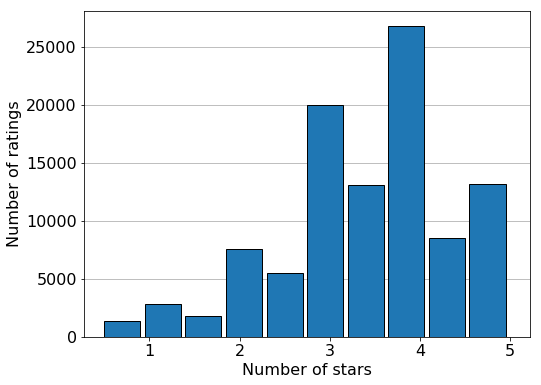

In [0]:
df1.rating.plot.hist(ec='k', width=0.4, zorder=2)
plt.grid(axis='y')
plt.ylabel('Number of ratings')
plt.xlabel('Number of stars')

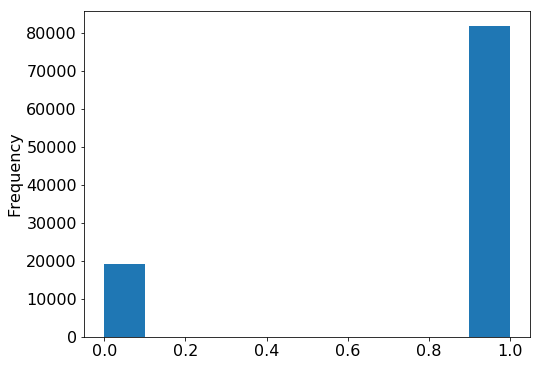

In [0]:
df1['like'] = df1['rating'] >= 3
df1.like = df1.like.astype(int)
df1.like.plot.hist()

In [0]:
m1 = df2[df2.title.str.startswith('Mulholland Drive')].movieId.values[0]
m2 = df2[df2.title.str.startswith('Usual')].movieId.values[0]
print(m1, m2)

print(df2[df2.title.str.startswith('Mulholland Drive')])
print(df2[df2.title.str.startswith('Usual')])


4848 50
     movieId                    title                                  genres
3544    4848  Mulholland Drive (2001)  Crime|Drama|Film-Noir|Mystery|Thriller
   movieId                       title                  genres
46      50  Usual Suspects, The (1995)  Crime|Mystery|Thriller


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1, df1.like,
                                                    stratify=df1.userId, 
                                                    test_size=0.3)

In [0]:
for df in (df1, X_train, X_test):
    print(len(df.movieId.unique()), len(df.userId.unique()))

In [0]:
data = X_train
user_idx = data.userId.cat.codes.values
n_users = data.userId.cat.categories.size

movie_idx = data.movieId.cat.codes.values
n_movies = data.movieId.cat.categories.size

observed = y_train

In [0]:
data[data.movieId==m1].movieId.cat.codes.values

In [0]:
obs = np.zeros((len(data), 2)) -999
# obs1 = np.zeros((len(data))) - 999
# obs2 = np.zeros((len(data))) - 999


idx = np.where(movie_idx==5889)[0]
for row in idx:
    obs[row,:] = [0,1]
#     obs1[row] = 0
#     obs2[row] = 1
    
idx = np.where(movie_idx==5716)[0]
for row in idx:
    obs[row,:] = [1,0]
#     obs1[row] = 1
#     obs2[row] = 0
    
obs_masked = np.ma.masked_array(obs, mask=obs==-999)
# obs1_masked = np.ma.masked_array(obs1, mask=obs1==-999)
# obs2_masked = np.ma.masked_array(obs2, mask=obs2==-999)

/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1331: UserWarning: Data in trait_ contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


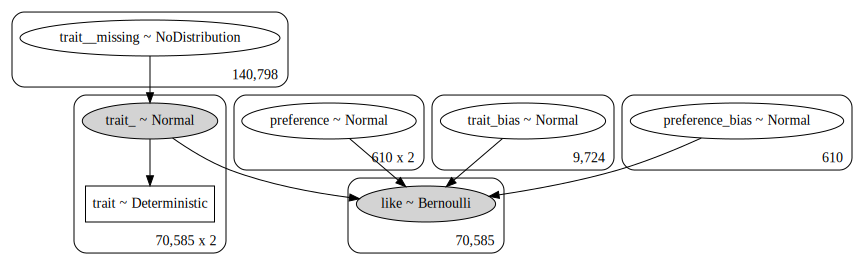

In [0]:
data = X_train
user_idx = data.userId.cat.codes.values
n_users = data.userId.cat.categories.size

movie_idx = data.movieId.cat.codes.values
n_movies = data.movieId.cat.categories.size

observed = y_train

with pm.Model() as model1:

    n_traits = 2
    
    trait_ = pm.Normal('trait_', mu=0, sigma=np.sqrt(1/np.sqrt(n_traits)), shape=(n_movies, n_traits), observed=obs_masked)
    trait = pm.Deterministic('trait', trait_)
    
    preference = pm.Normal('preference', mu=0, sigma=np.sqrt(1/np.sqrt(n_traits)), shape=(n_users, n_traits))
    
    trait_bias = pm.Normal('trait_bias', mu=0, sd=np.sqrt(10), shape=n_movies)
    preference_bias = pm.Normal('preference_bias', mu=0, sd=np.sqrt(10), shape=n_users)
    
    
    score = (tt.sum(tt.mul(trait_[movie_idx], 
                           preference[user_idx]))
             + trait_bias[movie_idx] 
             + preference_bias[user_idx])
            
    like = pm.Bernoulli('like', p=pm.math.sigmoid(score), observed=observed)
    

pm.model_to_graphviz(model1)

In [0]:
from pymc3.variational.callbacks import CheckParametersConvergence
with model1:
    mean_post = pm.fit(method='advi', callbacks=[CheckParametersConvergence()])
    #post = pm.sample(draws=300, tune=200)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 3.6297e+06: 100%|██████████| 10000/10000 [10:33<00:00, 16.02it/s]


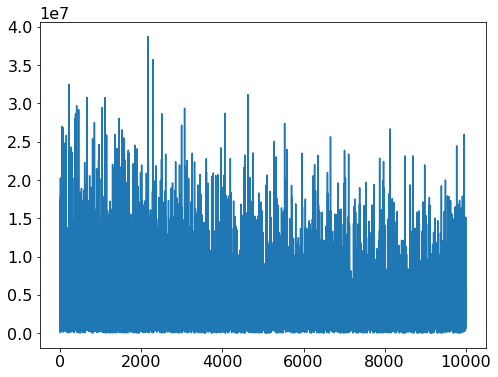

In [0]:
plt.plot(mean_post.hist)

In [0]:
post = mean_post.sample(500)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [0]:
post_trait = np.swapaxes(post['trait'],0,1)
post_trait = np.swapaxes(post_trait,1,2)
post_trait.shape

(70585, 2, 500)

In [0]:
coords = np.zeros(post_trait.shape[:-1])
for i, movie in enumerate(post_trait):
    for j, trait in enumerate(movie):
        mean = np.mean(trait)
        coords[i,j] = mean

(-0.3, 0.3)

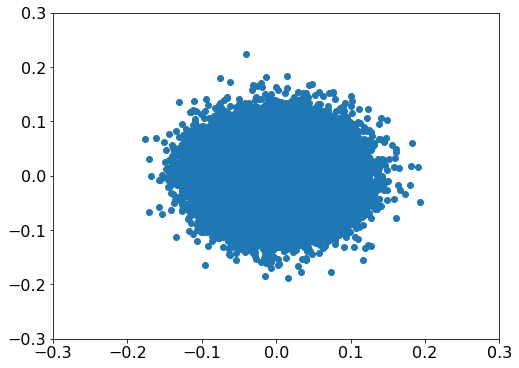

In [0]:
plt.scatter(coords[:,0], coords[:,1])
plt.xlim([-.3, .3])
plt.ylim([-.3, .3])

### Not working, scale is much shorter than in book example...